In [117]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)

sns.set_theme(style="white", palette=None)
%matplotlib inline

In [3]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

  Using cached fury-0.8.0-py3-none-any.whl (349 kB)
  Using cached vtk-9.2.2-cp38-cp38-win_amd64.whl (49.3 MB)
  Attempting uninstall: vtk
    Found existing installation: vtk -PKG-VERSION


ERROR: Cannot uninstall 'vtk'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


# load the data  (TODO : importer les autres datas de open neuro)

In [17]:
img = nib.load('sub-03_func_sub-03_task-dis_run-01_bold.nii')
data = img.get_data()
data.shape

C:\Users\maxim\AppData\Local\Temp\ipykernel_13424\1248650069.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


(64, 64, 30, 166)

In [14]:
df = pd.read_csv('sub-03_func_sub-03_task-dis_run-01_events.tsv', sep ='\t')
df.head(10)

,onset,duration,condition,item,key,RT
0,12,22,H_II,33,4,1.656
1,44,22,F_PHI,11,3,1.656
2,76,22,E_NA,57,1,1.352
3,108,22,B_PSA,22,1,1.371
4,140,22,I_PI,42,3,2.379
5,172,22,D_PA,41,1,0.645
6,204,22,G_PSI,24,3,2.688
7,236,22,J_NI,60,1,0.866
8,268,22,A_PHA,4,1,1.885
9,300,22,C_IA,29,3,2.885


***Description of the dataset: ***

The data set is calles : "Moral judgments of intentional and accidental moral violations across Harm and Purity domains".
Patients are exposed to different types of violence. We will investigate which area of the brain is stimulated when exposed to accidental or intentional harm.   
   
In this first dataset, the patient is looking at a serie of 10 events each labeled in the column 'condition'. Here is the meaning of each condition :
- A_PHA: Accidental physical harms
- B_PSA: Accidental psychological harms
- C_IA: Accidental incest violations
- D_PA: Accidental pathogen violations
- E_NA: Accidental neutral scenarios
- F_PHI: Intentional physical harms
- G_PSI: Intentional psychological harms
- H_II: Intentional incest violations
- I_PI: Intentional pathogen violations
- J_NI: Intentional neutral scenarios

The data has a 4D shape since it represents the acquisition signal per voxel at a given time.   

***We will try to answer the followinf question :***

What brain region is involoved when visualizing moral violation across harm and purity domain? Is there any different pattern between accidental scenario and intentional one?


## Methodology 

Our first goal will be to project the original voxel-dimensional data matrix (time-by-voxels) into a lower-dimensional "component" matrix space (time-by-component) without losing significant information.   

To do so, we will first, run a PCA on our 166 voxels. This will indicate us basises with maximum information. 
Mathematicaly, we take the covariance matrix $X^T\dot{X}$ and apply an SVD on it i.e. we resolve the following equality :    
$C = X^T\dot{X} = US^2U^T$ (this can be done simply by using the numpy function : np.linalg.svd).   
Singular vectors $u_k$ from the Matrix U, will give us eigenvectors of C.   
By sorting the eigenvectors by decreasing order, we obtain dircetions where variances are maximal i.e. basis with maximum of information.



### Preprocessing 

In [18]:
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

In [29]:
print(vol_shape)
print(n_vols)

(64, 64, 30)
166


In [22]:
first_two = data[..., :2]
first_two.shape

(64, 64, 30, 2)

In [23]:
# Set N to be the number of voxels in a volume
N = np.prod(vol_shape)
# Reshape to 2D array with first dimension length N
first_two = first_two.reshape((N, 2))
first_two.shape
# Transpose to 2 by N array
first_two = first_two.T
first_two.shape

(2, 122880)

In [51]:
# Calculate the mean across columns
row_means = np.mean(first_two, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = first_two - row_means
# Show the means over the columns, after the subtraction
np.mean(X, axis=1)

array([6.6317322e-14, 5.1159077e-14])

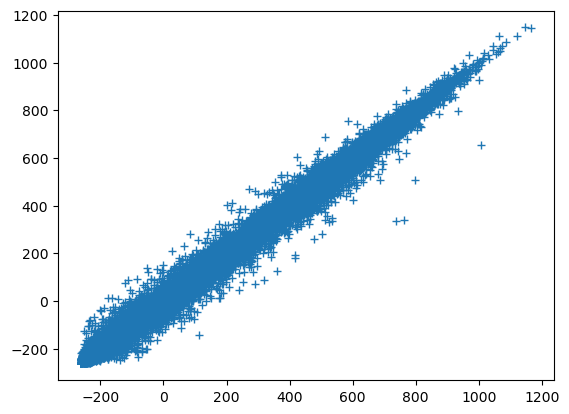

In [25]:
# Plot the signal in the first row against the signal in the second
plt.plot(X[0], X[1], '+')

Voxel1 and voxel2 are very correlated since X[0] vs X[1] form a line close to X[0]=X[1]. Maybe it is due to the time proximity. Let see with random ones...

38 73


Text(0, 0.5, 'Voxel 73')

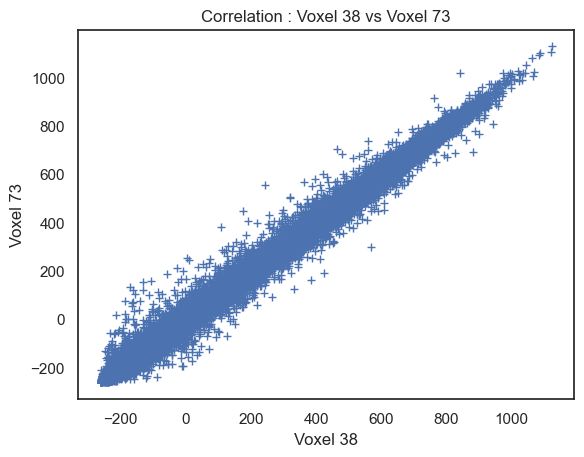

In [163]:
r1, r2 = np.random.randint(low=0, high=n_vols, size=2, dtype=int)
print(r1, r2)

d1 = data[..., r1]
d2 = data[..., r2]

# Reshape to 2D array with first dimension length N
d1 = d1.reshape((N, 1))
d2 = d2.reshape((N, 1))
two_random = np.hstack((d1, d2))
# Transpose to 2 by N array
two_random = two_random.T
two_random.shape

# Calculate the mean across columns
row_means_2 = np.mean(two_random, axis=1)
# Row means copied N times to become a 2 by N array
row_means_2 = np.outer(row_means_2, np.ones(N))
# Subtract the means for each row, put the result into X
X_2 = two_random - row_means_2
# Show the means over the columns, after the subtraction
np.mean(X_2, axis=1)

plt.plot(X_2[0], X_2[1], '+')
plt.title("Correlation : Voxel %d vs Voxel %d" %(r1, r2))
plt.xlabel("Voxel %d" %(r1))
plt.ylabel("Voxel %d" %(r2))

Take all the data, not only the 2 first one

In [161]:
#take the whole data
d = np.zeros((N, 1))
for i in range(data.shape[-1]):
    d = np.hstack((d, data[..., i].reshape((N, 1))))

#remove the first column of ones
d = np.delete(d, 0, axis=1)
d = d.T
print("shape of d : ", d.shape)

shape of d :  (166, 122880)


In [194]:
# Calculate the mean across columns
row_means_d = np.mean(d, axis=1)
# Row means copied N times to become a 166 by N array
row_means_d = np.outer(row_means_d, np.ones(N))
# Subtract the means for each row, put the result into X
X_d = d - row_means_d
# Show the means over the columns, after the subtraction
np.mean(X_d, axis=1)

(166, 122880)


array([ 6.63173220e-14,  5.11590770e-14, -6.63173220e-14,  1.89478063e-15,
       -7.57912251e-15,  4.92642963e-14,  6.82121026e-14, -3.78956126e-15,
       -1.89478063e-15,  4.92642963e-14, -4.92642963e-14,  3.78956126e-15,
       -8.71599089e-14,  1.89478063e-15,  6.82121026e-14, -4.92642963e-14,
        3.78956126e-15, -3.78956126e-15, -1.89478063e-15, -4.92642963e-14,
       -8.71599089e-14,  1.89478063e-15, -6.06329801e-14,  4.92642963e-14,
       -6.82121026e-14, -5.11590770e-14, -5.11590770e-14, -7.57912251e-15,
        1.89478063e-15, -1.51582450e-14, -1.89478063e-15, -1.51582450e-14,
        4.92642963e-14, -7.57912251e-15, -3.78956126e-15,  6.63173220e-14,
       -1.89478063e-15,  0.00000000e+00,  6.82121026e-14, -6.82121026e-14,
       -7.95807864e-14,  6.06329801e-14,  6.82121026e-14,  4.92642963e-14,
        0.00000000e+00,  3.78956126e-15, -3.78956126e-15, -4.92642963e-14,
        1.51582450e-14, -4.92642963e-14,  1.89478063e-15, -6.82121026e-14,
       -1.89478063e-15, -

# Apply PCA

In [192]:
X_d.shape

(166, 122880)

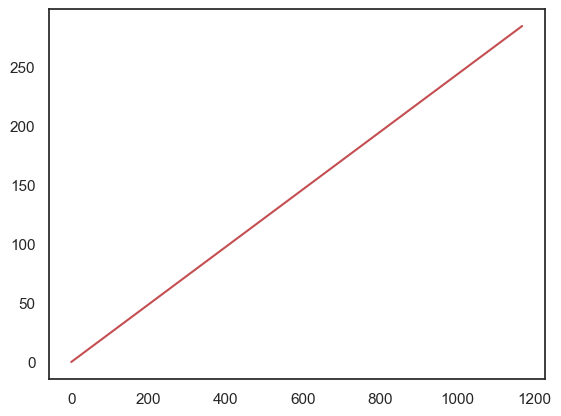

In [196]:
# Compute the covariance matrix 
covariance_matrix = X_d@X_d.T

# Apply SVD to get U, S, VT matrices from covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix)

# Plot the signal in the first row against the signal in the second
# Plot line corresponding to a scaled version of the first principal component
#plt.plot(X_d[0], X[1], '+') we don't plot anymore the 2 first but 166 first, so we don't...
scaled_u = U[0, :] *-15000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r-')

In [198]:
# Calculate the scalar projections for projecting X onto the vectors in U.
# Put the result into a new array C.
C = U.T.dot(d)
C.shape

# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (d.shape[0],))
print(C_vols.shape)

#- Break 4D array into 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]
vol10 = C_vols[..., 10]
vol50 = C_vols[..., 50]

(64, 64, 30, 166)


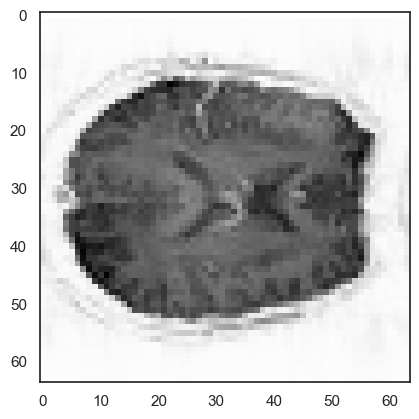

In [202]:
plt.imshow(vol0[:, :, 13], cmap='gray')

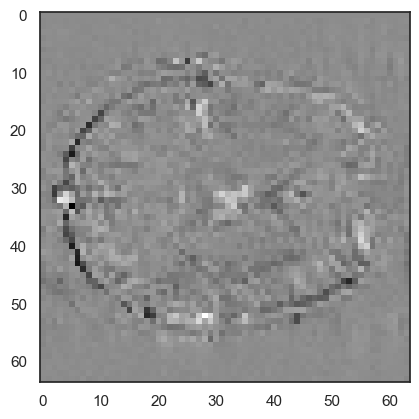

In [203]:
plt.imshow(vol1[:, :, 13], cmap='gray')

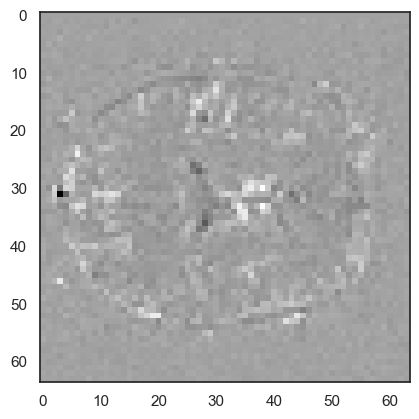

In [204]:
plt.imshow(vol10[:, :, 13], cmap='gray')

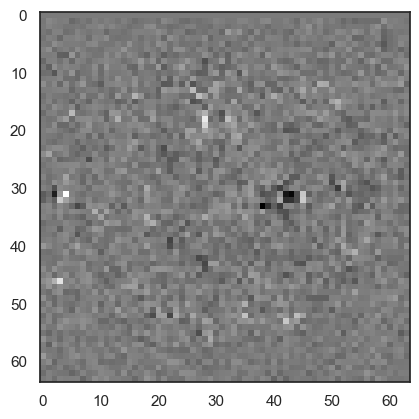

In [205]:
plt.imshow(vol50[:, :, 13], cmap='gray')

## Remark

We lose more and more information on the plot as the eigen vector become small. From a certain value i, C[:,:,i] become only noise.